# `xWRF` and `metpy`

In this tutorial, we will show you how `xWRF` enables a seamless integration of WRF data with [`metpy`](https://unidata.github.io/MetPy/latest/). In the end, we will have a skewT plot at a lat-lon location in the simulation domain. Much of this tutorial was adapted from [`metpy`](https://unidata.github.io/MetPy/latest/tutorials/upperair_soundings.html).

## Loading the data

First of all, we load the data and use the simple `.xwrf.postprocess()` API.

In [1]:
import xwrf

ds = xwrf.tutorial.open_dataset("wrfout").xwrf.postprocess()
ds

<xarray.Dataset>
Dimensions:                    (y: 185, x: 200, z: 41, x_stag: 201, y_stag: 186)
Coordinates:
    XLAT                       (y, x) float32 ...
    XLONG                      (y, x) float32 ...
    XTIME                      datetime64[ns] ...
  * x                          (x) float64 -8.794e+04 -8.694e+04 ... 1.111e+05
  * y_stag                     (y_stag) float64 -9.999e+04 ... 8.501e+04
  * y                          (y) float64 -9.949e+04 -9.849e+04 ... 8.451e+04
  * x_stag                     (x_stag) float64 -8.844e+04 ... 1.116e+05
  * z                          (z) float32 0.9969 0.9899 ... 0.008311 0.002679
    Time                       datetime64[ns] 2018-10-16
Data variables:
    Times                      |S19 b'2018-10-16_00:00:00'
    U                          (z, y, x_stag) float32 ...
    V                          (z, y_stag, x) float32 ...
    QVAPOR                     (z, y, x) float32 ...
    PSN                        (y, x) float32 ...
    wrf_projection             object +proj=lcc +x_0=0 +y_0=0 +a=6370000 +b=6...
    air_potential_temperature  (z, y, x) float32 293.1 293.0 ... 496.7 496.7
    air_pressure               (z, y, x) float32 9.606e+04 ... 5.255e+03
Attributes: (12/149)
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2018-10-15_00:00:00
    SIMULATION_START_DATE:           2018-10-15_00:00:00
    WEST-EAST_GRID_DIMENSION:        201
    SOUTH-NORTH_GRID_DIMENSION:      186
    BOTTOM-TOP_GRID_DIMENSION:       42
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

## Sampling

Then, we sample the dataset at the desired location using `pyproj`. I selected the German Weather Service station at Mannheim, which is close to the middle of the simulation domain.

In [2]:
import numpy as np
from pyproj import Transformer, CRS


def sample_wrf_ds_at_latlon(ds, lat, long):
    trf = Transformer.from_crs(CRS.from_epsg(4326), ds.wrf_projection.item(), always_xy=True)
    x, y = ([var] if np.isscalar(var) else var for var in trf.transform(long, lat))
    return ds.interp(x=x, y=y, x_stag=x, y_stag=y)

In [3]:
ds = sample_wrf_ds_at_latlon(ds, 49.5091090731333, 8.553966628049963)
ds

<xarray.Dataset>
Dimensions:                    (y: 1, x: 1, z: 41, x_stag: 1, y_stag: 1)
Coordinates:
    XLAT                       (y, x) float64 49.51
    XLONG                      (y, x) float64 8.554
    XTIME                      datetime64[ns] 2018-10-16
  * z                          (z) float32 0.9969 0.9899 ... 0.008311 0.002679
    Time                       datetime64[ns] 2018-10-16
  * x                          (x) float64 3.893e+03
  * y                          (y) float64 -5.552e+03
  * x_stag                     (x_stag) float64 3.893e+03
  * y_stag                     (y_stag) float64 -5.552e+03
Data variables:
    Times                      |S19 b'2018-10-16_00:00:00'
    U                          (z, y, x_stag) float64 0.0005943 ... -0.3269
    V                          (z, y_stag, x) float64 -0.5678 -0.466 ... -6.814
    QVAPOR                     (z, y, x) float64 0.005645 0.005644 ... 2.845e-06
    PSN                        (y, x) float64 0.0
    wrf_projection             object +proj=lcc +x_0=0 +y_0=0 +a=6370000 +b=6...
    air_potential_temperature  (z, y, x) float64 289.7 291.6 ... 483.6 498.8
    air_pressure               (z, y, x) float64 1.001e+05 ... 5.255e+03
Attributes: (12/149)
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2018-10-15_00:00:00
    SIMULATION_START_DATE:           2018-10-15_00:00:00
    WEST-EAST_GRID_DIMENSION:        201
    SOUTH-NORTH_GRID_DIMENSION:      186
    BOTTOM-TOP_GRID_DIMENSION:       42
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

## Computation of desired quantities

Now we have to compute the quantities [`metpy`](https://unidata.github.io/MetPy/latest/) uses for the skewT. For that we have to first quantify the WRF data and then convert the data to the desired units.

In [4]:
import metpy
import metpy.calc as mpcalc
import pint_xarray


ds = ds.metpy.quantify()
ds['dew_point_temperature'] = mpcalc.dewpoint(
    mpcalc.vapor_pressure(ds.air_pressure, ds.QVAPOR)
).pint.to("degC")
ds['air_temperature'] = mpcalc.temperature_from_potential_temperature(
    ds.air_pressure, ds.air_potential_temperature
).pint.to("degC")
ds['air_pressure'] = ds.air_pressure.pint.to("hPa")

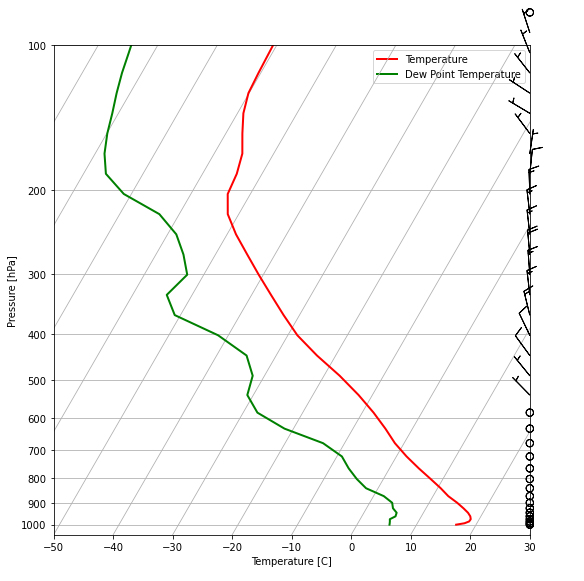

In [5]:
import matplotlib.pyplot as plt
from metpy.plots import SkewT

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Make the dimensions of the data palatable to metpy
if len(ds.dims) > 1:
    ds = ds.isel(x=0, x_stag=0, y=0, y_stag=0)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(ds.air_pressure, ds.air_temperature, 'r', linewidth=2, label='Temperature')
skew.plot(
    ds.air_pressure, ds.dew_point_temperature, 'g', linewidth=2, label='Dew Point Temperature'
)
skew.plot_barbs(ds.air_pressure, ds.U, ds.V)

# Make the plot a bit prettier
plt.xlim([-50, 30])
plt.xlabel('Temperature [C]')
plt.ylabel('Pressure [hPa]')
plt.legend().set_zorder(1)

# Show the plot
plt.show()